# [LVV-T235] - M13T-012: Position Repeatability After Parking - SITCOM-810

Notebook containing data analysis for the [LVV-T235] test case and adressing the ticket [SITCOM-810]
The purpose of the notebook is to fit a line to the final raised position and confirm that the slope is close to 0

This notebook is derived from [LVV-T235-analysis.ipynb]

The script used to run this test case can be found in [lsst-ts/ts_m1m3supporttesting/M13T012.py].  

[LVV-T235]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T235
[lsst-ts/ts_m1m3supporttesting/M13T012.py]: https://github.com/lsst-ts/ts_m1m3supporttesting/blob/develop/M13T012.py
[SITCOM-810]: https://jira.lsstcorp.org/browse/SITCOM-810
[LVV-T235-analysis.ipynb]: https://github.com/lsst-sitcom/notebooks_vandv/blob/develop/notebooks/tel_and_site/subsys_req_ver/m1m3/LVV-T235-analysis.ipynb

## Prepare Notebook

In [1]:
test_case = "LVV-T235"
test_exec = "LVV-E985"

t_start = "2023-03-07T18:48:20" # Exact time clean up initial fault
t_end = "2023-03-07T19:30:00"

#t_start = "2023-05-04T01:07:00" # Exact time clean up initial fault
#t_end = "2023-05-04T03:52:00"


delta_t = 2 # seconds

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import itertools as itt
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from astropy import units as u
from astropy.time import Time, TimezoneInfo

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3

## Query Data

In [4]:
pos_columns = ["xPosition", "yPosition"]
delta_t = pd.Timedelta(delta_t, "seconds")
client = vandv.efd.create_efd_client()

In [5]:
# Get data from the Independent Measuring System (ims)
df_ims = await client.select_time_series(
    "lsst.sal.MTM1M3.imsData", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)

df_ims = df_ims.set_index("private_rcvStamp")
df_ims.index = pd.to_datetime(df_ims.index, unit="s")

# Get x and y position columns and convert to milimeter
df_ims = df_ims[pos_columns] * 1e3

In [6]:
df_state = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_detailedState", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)

df_state["detailedStateName"] = \
    df_state["detailedState"].map(lambda x: MTM1M3.DetailedState(x).name)

df_state = df_state.set_index("private_rcvStamp")
df_state.index = pd.to_datetime(df_state.index, unit="s")

In [7]:
df_cmdPos = await client.select_time_series(
    "lsst.sal.MTM1M3.command_positionM1M3", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)

df_cmdPos = df_cmdPos.set_index("private_rcvStamp")
df_cmdPos.index = pd.to_datetime(df_cmdPos.index, unit="s")
df_cmdPos = df_cmdPos[pos_columns]
df_cmdPos = df_cmdPos * 1e3 # Convert meter to milimeter to make is easier to analyse

In [8]:
df_HPState = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_hardpointActuatorState", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)

df_HPState = df_HPState.set_index("private_rcvStamp")
df_HPState.index = pd.to_datetime(df_HPState.index, unit="s")

## Initial Data Display 

The plot below shows the whole data collection.  
There you can see a loop repeated seven times. 

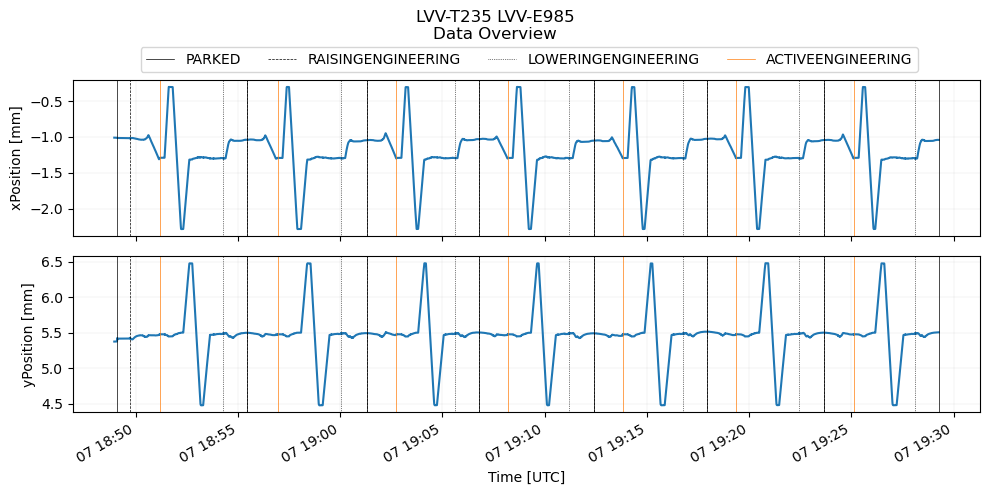

In [9]:
title = f"{test_case} {test_exec}\nData Overview"
fig, axs = plt.subplots(num=title, nrows=2, sharex=True, figsize=(10, 5))

when_parked = df_state[df_state["detailedStateName"] == "PARKED"].index
when_rasing = df_state[df_state["detailedStateName"] == "RAISINGENGINEERING"].index
when_lowering = df_state[df_state["detailedStateName"] == "LOWERINGENGINEERING"].index
when_active = df_state[df_state["detailedStateName"] == "ACTIVEENGINEERING"].index

for i, label in enumerate(pos_columns):
    ax = axs[i]
    ax.plot(df_ims[label])
    
    for idx in when_parked:
        l1 = ax.axvline(idx, lw="0.5", c="k")
        
    for idx in when_rasing:
        l2 = ax.axvline(idx, lw="0.5", c="k", ls="--")
        
    for idx in when_lowering:
        l3 = ax.axvline(idx, lw="0.5", c="k", ls=":")
        
    for idx in when_active:
        l4 = ax.axvline(idx, lw="0.5", c="C1", ls="-")

    ax.grid(":", lw=0.1)
    ax.set_xlabel("Time [UTC]")
    ax.set_ylabel(f"{label} [mm]")

fig.legend(
    [l1, l2, l3, l4], 
    ["PARKED", "RAISINGENGINEERING", "LOWERINGENGINEERING", "ACTIVEENGINEERING"], 
    ncols=4, 
    loc="upper right", 
    bbox_to_anchor=(0.93, 0.92)
)
fig.suptitle(title + "\n")
fig.autofmt_xdate()
fig.tight_layout()

plt.show()

### Find and Subtract Reference Value

As you can see, the initial M1M3 position is not zero on both x and y directions.  
It will be much easier if we can do the data analysis on data that is centered at zero.  
From the plot above, we can get the telemetry close to when the ACTIVEENGINEERING detailed state is as a reference.
  
The cell bellow shows how we extract the median near the detailed state event associated with ACTIVEENGINEERING.

In [10]:
when_active = df_state[df_state["detailedStateName"] == "ACTIVEENGINEERING"].index

sub_df = pd.DataFrame(columns=df_ims.columns.to_list())

for idx in when_active:
    dt = pd.Timedelta(2, "sec")
    temp = df_ims.loc[idx:idx+dt]
    sub_df = pd.concat((sub_df, temp), axis=0)
    
median_vals = sub_df.median()
print(median_vals)

xPosition   -1.292542
yPosition    5.479346
dtype: float64


Now we copy the IMS dataframe and subtract the reference values from all the position columns. 

In [11]:
df_results = df_ims.copy() 

for col in pos_columns:
    df_results[col] = df_results[col] - median_vals[col]

and plot them...

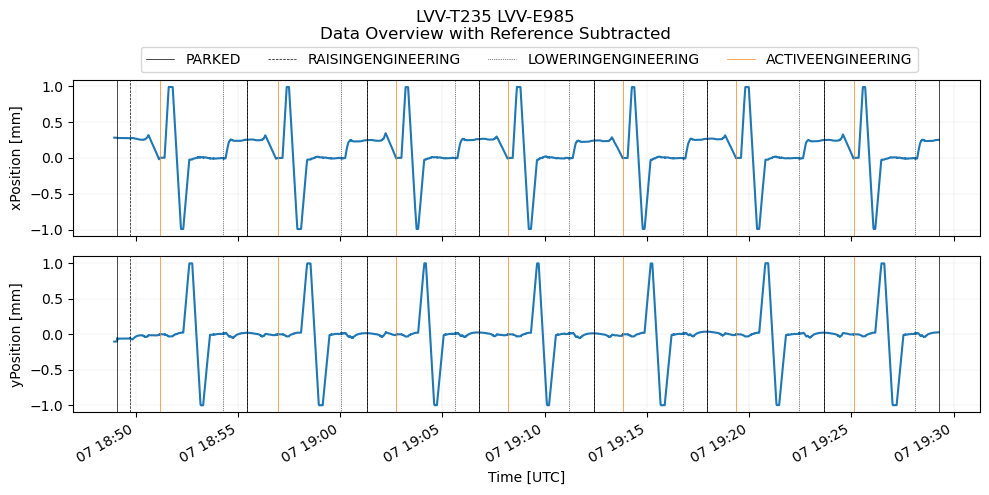

In [12]:
title = f"{test_case} {test_exec}\nData Overview with Reference Subtracted"
fig, axs = plt.subplots(num=title, nrows=2, sharex=True, figsize=(10, 5))

when_parked = df_state[df_state["detailedStateName"] == "PARKED"].index

for i, label in enumerate(["xPosition", "yPosition"]):
    ax = axs[i]
    ax.plot(df_results[label])
    
    for idx in when_parked:
        ax.axvline(idx, lw="0.5", c="k")
        
    for idx in when_rasing:
        ax.axvline(idx, lw="0.5", c="k", ls="--")
        
    for idx in when_lowering:
        ax.axvline(idx, lw="0.5", c="k", ls=":")
        
    for idx in when_active:
        ax.axvline(idx, lw="0.5", c="C1", ls="-")
        
    ax.grid(":", lw=0.1)
    ax.set_xlabel("Time [UTC]")
    ax.set_ylabel(f"{label} [mm]")
    
fig.legend(
    [l1, l2, l3, l4], 
    ["PARKED", "RAISINGENGINEERING", "LOWERINGENGINEERING", "ACTIVEENGINEERING"], 
    ncols=4, 
    loc="upper right", 
    bbox_to_anchor=(0.93, 0.92)
)
    
fig.suptitle(title + "\n")
fig.autofmt_xdate()
fig.tight_layout()

plt.show()

### Zoom Single Loop

The plots above show the whole data acquisition process.  
They show a loop of seven iterations through the different positions.  
The plot below shows a zoom in the first interation that starts in the first PARK state event and finished in the second PARK state event. 
It also shows the commanded positions 

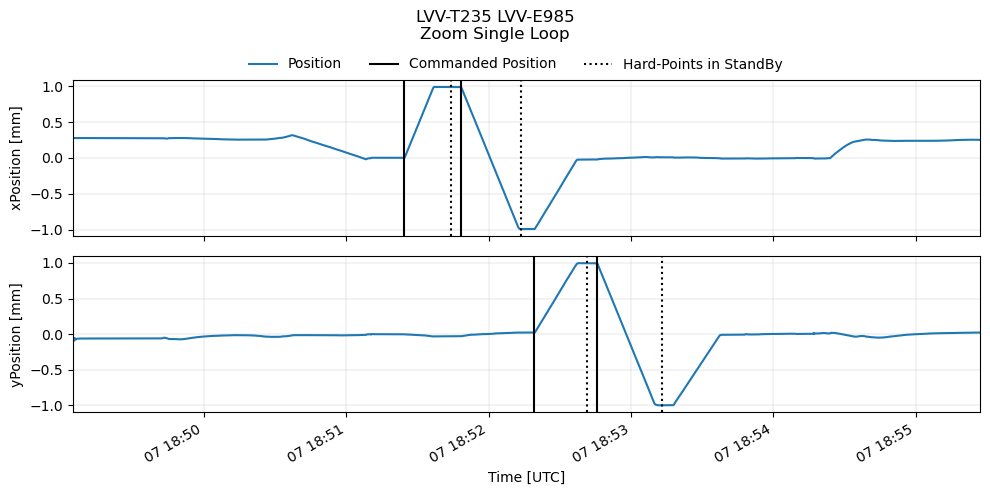

In [13]:
title = f"{test_case} {test_exec}\nZoom Single Loop"
fig, axs = plt.subplots(num=title, nrows=2, sharex=True, figsize=(10, 5))

when_parked = df_state[df_state["detailedStateName"] == "PARKED"].index
axes = ["x", "y"]
colors = ["g", "b"]

for i, label in enumerate(["xPosition", "yPosition"]):
    ax = axs[i]
    sub_df_results = df_results[when_parked[0]:when_parked[1]]
    sub_df_cmdPos = df_cmdPos[when_parked[0]:when_parked[1]]
    
    l1, = ax.plot(sub_df_results[label])
    
    sub_sub_df_cmdPos = sub_df_cmdPos[sub_df_cmdPos[label] != 0]

    for idx in sub_sub_df_cmdPos.index:
                
        sub_df_HPState = df_HPState[idx:]        
        mask = (sub_df_HPState[[f"motionState{j}" for j in range(1, 6)]] == 0).all(axis=1) 
        idx_hp = sub_df_HPState[mask].index[0]

        l3 = ax.axvline(idx_hp, c="k", ls=":")
        l2 = ax.axvline(idx, c="k", ls="-")

    ax.grid(":", lw=0.2)
    ax.set_xlabel("Time [UTC]")
    ax.set_xlim(sub_df_results.index[0], sub_df_results.index[-1])
    ax.set_ylabel(f"{label} [mm]")

leg = fig.legend(
    [l1, l2, l3], 
    ["Position", "Commanded Position", "Hard-Points in StandBy"], 
    ncols=3,
    loc="upper right",
    bbox_to_anchor=(0.80, 0.91)
)
leg.get_frame().set_linewidth(0.0)

fig.suptitle(title + "\n")
fig.autofmt_xdate()
fig.tight_layout()

plt.show()

## Super Zoom in each commanded position

Here we do a preliminary analysis on each of the commanded X/Y position.  
We are interested by the data corresponding to the flat part of the curve after the Commanded Position and 
up to the Hard Point in StandBy

In [14]:
# Select timestamps corresponding to the ACTIVEENGINEERING states
sub_df_state_AE = df_state[df_state["detailedStateName"] == "ACTIVEENGINEERING"]
index_AE = sub_df_state_AE.index

# Select timestamps corresponding to the LOWERENGINEERING states
sub_df_state_LOW = df_state[df_state["detailedStateName"] == "LOWERINGENGINEERING"]
index_LOW = sub_df_state_LOW.index

sub_df_cmdPos = df_cmdPos[index_AE[0]:index_LOW[0]]

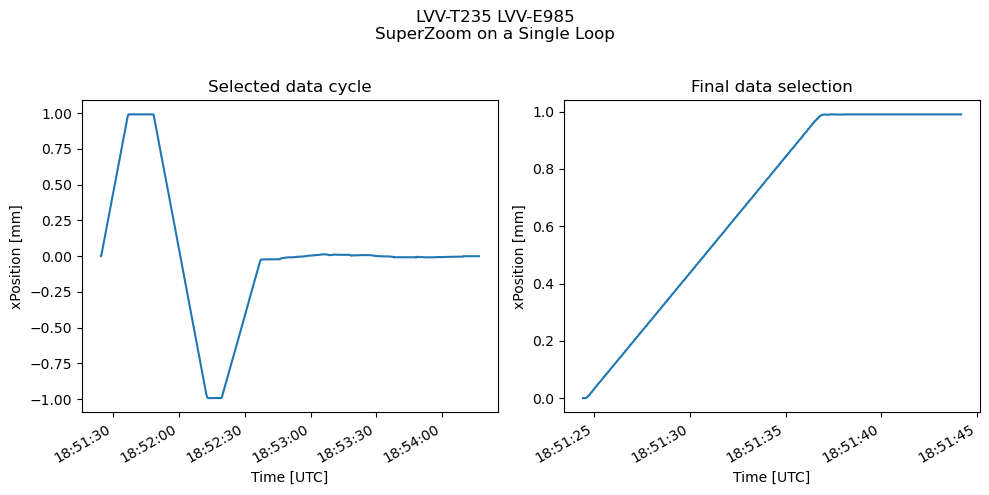

In [15]:
# Between successive ACTIVEENGINEERING and LOWERINGENGINEERING states we select timestamps where a command has been issued
# on the selected axis ("xPosition" in this case)
sub_sub_df_cmdPos = sub_df_cmdPos[sub_df_cmdPos["xPosition"] != 0]
index_cmdPos = sub_sub_df_cmdPos.index

# We then get the measured positions on the selected axis between the timestamps between the time when the command is
# issued and the next LOWERINGENGINEERING state
sub_df_results = df_results["xPosition"][index_cmdPos[0]:index_LOW[0]]

# Plot the measured position for these timestamps
title = f"{test_case} {test_exec}\nSuperZoom on a Single Loop"
fig, axs = plt.subplots(num=title, ncols=2, figsize=(10, 5))

axs[0].plot(sub_df_results)
axs[0].set_xlabel("Time [UTC]")
axs[0].set_ylabel("xPosition [mm]")
axs[0].set_title("Selected data cycle")

# We are now going to restrict the dataset to the region of interest
# We now get the Hard Point states in the same time period
sub_df_HPState = df_HPState[index_cmdPos[0]:index_LOW[0]]

# Select timestamps where all 6 Hard Points are in standby (motionState == 0) 
mask = (sub_df_HPState[[f"motionState{j}" for j in range(1, 6)]] == 0).all(axis=1) 
index_HP = sub_df_HPState[mask].index

axs[1].plot(sub_df_results[index_cmdPos[0]:index_HP[0]])
axs[1].set_xlabel("Time [UTC]")
axs[1].set_ylabel("xPosition [mm]")
axs[1].set_title("Final data selection")

fig.suptitle(title + "\n")
fig.autofmt_xdate()
fig.tight_layout()

In [17]:
# we are now selecting the data corresponding to the last second before the Hard Point is in a standby state
delta_t1 = pd.Timedelta(1, "seconds")
flat_position = sub_df_results[index_HP[0]-delta_t1:index_HP[0]]

# Fit a straight line through these data points
# if we have reached a stable position the slope (s0) should be close to 0
index_time = flat_position.index.to_numpy()

# The time is converted to miliseconds since the first ACTIVEENGINEERING state
time = (index_time - np.datetime64(index_AE[0])) / np.timedelta64(1, 'ms')
s0,s1 = np.polyfit(time, np.array(flat_position), 1)
print(f"Slope before reaching Hard Point in Standby state: {s0*1000} mm/s")

Slope before reaching Hard Point in Standby state: 1.0592598262626794e-06 mm/s


## Do the slope measurement on both axis (x and y) and on the whole dataset (multiple cycles)

In [18]:
delta_t1 = pd.Timedelta(1, "seconds")

sub_df_state_AE = df_state[df_state["detailedStateName"] == "ACTIVEENGINEERING"]
index_AE = sub_df_state_AE.index
sub_df_state_LOW = df_state[df_state["detailedStateName"] == "LOWERINGENGINEERING"]
index_LOW = sub_df_state_LOW.index

for i_AE in range(index_AE.size):
    print(i_AE)
    sub_df_cmdPos = df_cmdPos[index_AE[i_AE]:index_LOW[i_AE]]
    for i_pos, label in enumerate(["xPosition", "yPosition"]):
        sub_sub_df_cmdPos = sub_df_cmdPos[sub_df_cmdPos[label] != 0]
        index_cmdPos = sub_sub_df_cmdPos.index
        for i_pos, timestamp in enumerate(index_cmdPos):
            sub_df_results = df_results[label][timestamp:index_LOW[i_AE]]
            sub_df_HPState = df_HPState[timestamp:index_LOW[i_AE]]
            mask = (sub_df_HPState[[f"motionState{j}" for j in range(1, 6)]] == 0).all(axis=1)
            index_HP = sub_df_HPState[mask].index[0]
            sel_data = sub_df_results[index_HP-delta_t1:index_HP]
            time = sel_data.index.to_numpy()
            ts = (time - np.datetime64(index_AE[i_AE])) / np.timedelta64(1, 'ms')
            s0,s1 = np.polyfit(ts, np.array(sel_data), 1)
            print(f"{index_AE[i_AE]} - axis: {label} - target posision: {sub_sub_df_cmdPos[timestamp:timestamp][label][0]} - slope: {s0*1000} mm/s")

0
2023-03-07 18:51:10.082184704 - axis: xPosition - target posision: 1.0000000474974513 - slope: 1.0592598262626794e-06 mm/s
2023-03-07 18:51:10.082184704 - axis: xPosition - target posision: -1.0000000474974513 - slope: -0.018160572675295476 mm/s
2023-03-07 18:51:10.082184704 - axis: yPosition - target posision: 1.0000000474974513 - slope: -2.8886760671304284e-17 mm/s
2023-03-07 18:51:10.082184704 - axis: yPosition - target posision: -1.0000000474974513 - slope: -9.504660074681685e-05 mm/s
1
2023-03-07 18:56:56.231809792 - axis: xPosition - target posision: 1.0000000474974513 - slope: 0.0001938331555635714 mm/s
2023-03-07 18:56:56.231809792 - axis: xPosition - target posision: -1.0000000474974513 - slope: 4.426782603789857e-05 mm/s
2023-03-07 18:56:56.231809792 - axis: yPosition - target posision: 1.0000000474974513 - slope: -3.029641205862704e-07 mm/s
2023-03-07 18:56:56.231809792 - axis: yPosition - target posision: -1.0000000474974513 - slope: -3.6229428828959685e-07 mm/s
2
2023-03